In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:

# ===============================
# CELL 1: INSTALL AND IMPORT
# ===============================

!pip install unsloth
!pip install -U xformers trl peft accelerate bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.2/376.2 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.5/164.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.8.1
    Uninstalling accelerate-1.8.1:
      Successfully uninstalled accelerate-1.8.1


In [32]:
# ===============================
# IMPORTS AND SETUP
# ===============================
import pandas as pd
import torch
import json
import re
import random
import numpy as np
from collections import defaultdict
from datasets import Dataset
from transformers import AutoTokenizer, TrainingArguments, EarlyStoppingCallback
from unsloth import FastLanguageModel
from trl import SFTTrainer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# Configuration
MODEL_NAME = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"
MAX_SEQ_LENGTH = 1024
BATCH_SIZE = 2
EPOCHS = 3
LR = 2e-4
OUTPUT_DIR = "/content/drive/MyDrive/nsc/model/lasted"


In [34]:
# ===============================
# DATA PREPARATION
# ===============================
def create_game_features(game_moves):
    """สร้าง features จากการเดินหมากในเกม"""
    early_moves = game_moves.head(10)

    features = {
        'total_moves': len(early_moves),
        'player1_moves': len(early_moves[early_moves['player'] == 1]),
        'player2_moves': len(early_moves[early_moves['player'] == -1]),
        'horizontal_moves': 0,
        'vertical_moves': 0,
        'diagonal_moves': 0,
        'avg_distance': 0,
        'max_distance': 0
    }

    # วิเคราะห์ pattern การเดิน
    distances = []
    for _, move in early_moves.iterrows():
        row_diff = move['to_row'] - move['from_row']
        col_diff = move['to_col'] - move['from_col']

        if row_diff == 0 and col_diff != 0:
            features['horizontal_moves'] += 1
        elif row_diff != 0 and col_diff == 0:
            features['vertical_moves'] += 1
        else:
            features['diagonal_moves'] += 1

        distance = abs(row_diff) + abs(col_diff)
        distances.append(distance)

    if distances:
        features['avg_distance'] = sum(distances) / len(distances)
        features['max_distance'] = max(distances)

    return features

In [35]:
def format_prompt_for_training(situation, strategy_name, strategy_desc):
    """สร้าง prompt สำหรับการ train"""
    return f"""<|im_start|>system
คุณเป็นผู้เชี่ยวชาญการวิเคราะห์กลยุทธ์หมากหนีบ โปรดวิเคราะห์สถานการณ์การเดินหมากและแนะนำกลยุทธ์ที่เหมาะสม
<|im_end|>
<|im_start|>user
{situation}

โปรดแนะนำกลยุทธ์ที่เหมาะสมจากสถานการณ์นี้
<|im_end|>
<|im_start|>assistant
กลยุทธ์: {strategy_name}
เหตุผล: {strategy_desc}
<|im_end|>"""

In [36]:
def prepare_training_data(game_strategy_df, game_moves_df, strategy_descriptions):
    """เตรียมข้อมูลการ train"""
    strategy_lookup = {item['ชื่อกลยุทธ์']: item for item in strategy_descriptions}
    training_data = []

    for _, game in game_strategy_df.iterrows():
        # หาการเดินหมากของเกม
        game_moves = game_moves_df[
            (game_moves_df['iteration'] == game['iteration']) &
            (game_moves_df['game_number'] == game['game_number'])
        ].sort_values('move_number')

        if len(game_moves) < 5:
            continue

        # สร้าง features
        features = create_game_features(game_moves)

        # สร้าง situation description
        situation = f"""สถานการณ์เกมหมากหนีบ:
- จำนวนการเดินหมาก: {features['total_moves']} ตา
- ผู้เล่น 1: {features['player1_moves']} ตา, ผู้เล่น 2: {features['player2_moves']} ตา
- การเดินแนวนอน: {features['horizontal_moves']} ตา
- การเดินแนวตั้ง: {features['vertical_moves']} ตา
- ระยะทางเฉลี่ย: {features['avg_distance']:.1f} ช่อง"""

        # เพิ่มรายละเอียดการเดินหมาก 5 ตาแรก
        for i, (_, move) in enumerate(game_moves.head(5).iterrows()):
            situation += f"\nตาที่ {i+1}: ผู้เล่น {move['player']} เดิน ({move['from_row']},{move['from_col']}) → ({move['to_row']},{move['to_col']})"

        # หา strategy info
        strategy_name = game['strategy']
        strategy_info = strategy_lookup.get(strategy_name, {})
        strategy_desc = strategy_info.get('วิธีการเดินหมากหนีบ', strategy_name)

        # สร้าง training example
        prompt = format_prompt_for_training(situation, strategy_name, strategy_desc)

        training_data.append({
            "text": prompt,
            "strategy": strategy_name,
            "iteration": game['iteration'],
            "game_number": game['game_number']
        })

    return training_data

In [37]:
# ===============================
# LOAD DATA
# ===============================
print("Loading data...")
game_strategy_df = pd.read_csv('/content/drive/MyDrive/nsc/data/game_strategy_analysis_llm_limited.csv')
game_moves_df = pd.read_csv('/content/drive/MyDrive/nsc/data/game_move.csv')

with open('/content/drive/MyDrive/nsc/data/วิธีเดินหมากหนีบของแต่ละกลยุทธ์_สรุป.json', 'r', encoding='utf-8') as f:
    strategy_descriptions = json.load(f)

# เตรียมข้อมูล
all_training_data = prepare_training_data(game_strategy_df, game_moves_df, strategy_descriptions)

# แบ่งข้อมูล train/validation
train_data, val_data = train_test_split(
    all_training_data,
    test_size=0.2,
    random_state=42,
    stratify=[item['strategy'] for item in all_training_data]
)

print(f"Training examples: {len(train_data)}")
print(f"Validation examples: {len(val_data)}")

Loading data...
Training examples: 800
Validation examples: 200


In [38]:
train_data[:2]

[{'text': '<|im_start|>system\nคุณเป็นผู้เชี่ยวชาญการวิเคราะห์กลยุทธ์หมากหนีบ โปรดวิเคราะห์สถานการณ์การเดินหมากและแนะนำกลยุทธ์ที่เหมาะสม\n<|im_end|>\n<|im_start|>user\nสถานการณ์เกมหมากหนีบ:\n- จำนวนการเดินหมาก: 10 ตา\n- ผู้เล่น 1: 5 ตา, ผู้เล่น 2: 5 ตา  \n- การเดินแนวนอน: 2 ตา\n- การเดินแนวตั้ง: 8 ตา\n- ระยะทางเฉลี่ย: 2.0 ช่อง\nตาที่ 1: ผู้เล่น 1 เดิน (0,6) → (2,6)\nตาที่ 2: ผู้เล่น -1 เดิน (7,5) → (2,5)\nตาที่ 3: ผู้เล่น 1 เดิน (0,0) → (1,0)\nตาที่ 4: ผู้เล่น -1 เดิน (7,7) → (6,7)\nตาที่ 5: ผู้เล่น 1 เดิน (0,3) → (3,3)\n\nโปรดแนะนำกลยุทธ์ที่เหมาะสมจากสถานการณ์นี้\n<|im_end|>\n<|im_start|>assistant\nกลยุทธ์: คบไกลตีใกล้\nเหตุผล: ส่งหมากไปผูกมิตรในแนวไกลเพื่อเบี่ยงความสนใจศัตรู จากนั้นใช้หมากนั้นประสานกับหมากใกล้เพื่อหนีบกินเป้าหมายที่อยู่ใกล้ตัวศัตรูทันที\n<|im_end|>',
  'strategy': 'คบไกลตีใกล้',
  'iteration': 48,
  'game_number': 8},
 {'text': '<|im_start|>system\nคุณเป็นผู้เชี่ยวชาญการวิเคราะห์กลยุทธ์หมากหนีบ โปรดวิเคราะห์สถานการณ์การเดินหมากและแนะนำกลยุทธ์ที่เหมาะสม\n<|im_end|>\n<

In [39]:
# ===============================
# MODEL SETUP
# ===============================
print("Loading model...")
model, tokenizer = FastLanguageModel.from_pretrained(
    MODEL_NAME,
    max_seq_length=MAX_SEQ_LENGTH,
    load_in_4bit=True
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    use_gradient_checkpointing="unsloth"
)


Loading model...
==((====))==  Unsloth 2025.7.4: Fast Llama patching. Transformers: 4.53.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.7.4 patched 16 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [40]:
# ===============================
# TRAINING SETUP
# ===============================
train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
val_dataset = Dataset.from_pandas(pd.DataFrame(val_data))

def preprocess_function(examples):
    tokenized = tokenizer(
        examples["text"],
        max_length=MAX_SEQ_LENGTH,
        truncation=True,
        padding=False
    )
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["text"])
val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=["text"])

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    learning_rate=LR,
    weight_decay=0.01,
    warmup_steps=50,
    lr_scheduler_type="cosine",
    optim="adamw_torch",
    max_grad_norm=1.0,
    eval_strategy="steps",
    eval_steps=20,
    save_strategy="steps",
    save_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=True,
    logging_steps=10,
    report_to="none"
)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=training_args,
    dataset_text_field=None,
    max_seq_length=MAX_SEQ_LENGTH,
    packing=False,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [41]:
# ===============================
# EVALUATION FUNCTIONS
# ===============================
def extract_strategy_name(prediction_text):
    """แยกชื่อกลยุทธ์จากข้อความทำนาย"""
    # หาชื่อกลยุทธ์หลัง "กลยุทธ์:"
    pattern = r"กลยุทธ์:\s*(.+)"
    match = re.search(pattern, prediction_text)
    if match:
        return match.group(1).strip()

    # หาชื่อกลยุทธ์ที่รู้จัก
    known_strategies = [
        'ปิดฟ้าข้ามทะเล', 'ล้อมเวยช่วยจ้าว', 'อุบายขงเบ้ง',
        'ทำนองเมาท์', 'รอบคอบ', 'โจมตีรวดเร็ว'
    ]

    for strategy in known_strategies:
        if strategy in prediction_text:
            return strategy

    return "ไม่ระบุ"

def evaluate_predictions(model, tokenizer, val_data, max_samples=50):
    """ประเมินผลการทำนาย"""
    predictions = []
    true_labels = []

    FastLanguageModel.for_inference(model)

    print(f"Evaluating {min(max_samples, len(val_data))} samples...")

    for i, sample in enumerate(val_data[:max_samples]):
        try:
            # แยก prompt และ answer
            full_text = sample['text']
            prompt_parts = full_text.split('<|im_start|>assistant')
            if len(prompt_parts) < 2:
                continue

            prompt = prompt_parts[0] + '<|im_start|>assistant\n'
            true_strategy = sample['strategy']

            # Generate prediction
            inputs = tokenizer(
                prompt,
                return_tensors="pt",
                max_length=MAX_SEQ_LENGTH//2,
                truncation=True
            ).to(model.device)

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=100,
                    temperature=0.7,
                    do_sample=True,
                    pad_token_id=tokenizer.eos_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )

            response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            answer = response.replace(prompt, "").strip()

            # Extract predicted strategy
            predicted_strategy = extract_strategy_name(answer)

            predictions.append(predicted_strategy)
            true_labels.append(true_strategy)

            if i % 10 == 0:
                print(f"Processed {i+1}/{min(max_samples, len(val_data))} samples")

        except Exception as e:
            print(f"Error in sample {i}: {e}")
            predictions.append("ไม่ระบุ")
            true_labels.append(sample['strategy'])
            continue

    model.train()  # Switch back to training mode
    return predictions, true_labels

def plot_confusion_matrix(true_labels, predictions):
    """สร้าง confusion matrix"""
    unique_strategies = sorted(list(set(true_labels + predictions)))
    cm = confusion_matrix(true_labels, predictions, labels=unique_strategies)

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_strategies, yticklabels=unique_strategies)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Strategy')
    plt.ylabel('True Strategy')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def detailed_evaluation_report(true_labels, predictions):
    """สร้างรายงานการประเมินผลละเอียด"""
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Overall Accuracy: {accuracy:.3f}")

    # Classification report
    unique_strategies = sorted(list(set(true_labels + predictions)))
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, labels=unique_strategies))

    # Per-strategy performance
    print("\nPer-strategy Performance:")
    for strategy in unique_strategies:
        if strategy in true_labels:
            true_count = true_labels.count(strategy)
            pred_count = predictions.count(strategy)
            correct = sum(1 for t, p in zip(true_labels, predictions)
                         if t == strategy and p == strategy)

            precision = correct / pred_count if pred_count > 0 else 0
            recall = correct / true_count if true_count > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            print(f"  {strategy}:")
            print(f"    Precision: {precision:.3f}")
            print(f"    Recall: {recall:.3f}")
            print(f"    F1-Score: {f1:.3f}")
            print(f"    Support: {true_count}")

    return accuracy

def test_custom_prediction(model, tokenizer, custom_moves):
    """ทดสอบการทำนายกับข้อมูลใหม่"""
    situation = f"สถานการณ์เกมหมากหนีบ:\n{custom_moves}\n\nโปรดแนะนำกลยุทธ์ที่เหมาะสมจากสถานการณ์นี้"

    prompt = f"""<|im_start|>system
คุณเป็นผู้เชี่ยวชาญการวิเคราะห์กลยุทธ์หมากหนีบ โปรดวิเคราะห์สถานการณ์การเดินหมากและแนะนำกลยุทธ์ที่เหมาะสม
<|im_end|>
<|im_start|>user
{situation}
<|im_end|>
<|im_start|>assistant
"""

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=MAX_SEQ_LENGTH).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=200,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response.replace(prompt, "").strip()

In [42]:
# ===============================
# TRAINING
# ===============================
print("Starting training...")
trainer_stats = trainer.train()

Starting training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 800 | Num Epochs = 3 | Total steps = 300
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 11,272,192 of 1,247,086,592 (0.90% trained)


Step,Training Loss,Validation Loss
20,1.484300,1.190883
40,0.526100,0.458929
60,0.308300,0.245387
80,0.128300,0.094722
100,0.064100,0.056636
120,0.050600,0.052136
140,0.049800,0.049751
160,0.049400,0.047959
180,0.048300,0.046829
200,0.050100,0.046328


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [43]:
# Save model
trainer.save_model()
tokenizer.save_pretrained(OUTPUT_DIR)

('/content/drive/MyDrive/nsc/model/lasted/tokenizer_config.json',
 '/content/drive/MyDrive/nsc/model/lasted/special_tokens_map.json',
 '/content/drive/MyDrive/nsc/model/lasted/chat_template.jinja',
 '/content/drive/MyDrive/nsc/model/lasted/tokenizer.json')

In [45]:
output_path = "/content/drive/MyDrive/nsc/model/q4km"

# Export to Q4_K_M quantized GGUF
print("Exporting to Q4_K_M quantized GGUF format...")
model.save_pretrained_gguf(
    output_path,
    tokenizer,
    quantization_method="q4_k_m",
    push_to_hub=False
)

Exporting to Q4_K_M quantized GGUF format...


Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 1.0G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 3.19 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 16/16 [00:00<00:00, 24.58it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving /content/drive/MyDrive/nsc/model/q4km/pytorch_model.bin...
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: CMAKE detected. Finalizing some steps for installation.
Unsloth: [1] Converting model at /content/drive/MyDrive/nsc/model/q4km into f16 GGUF format.
The output location will be /content/drive/MyDrive/nsc/model/q4km/unsloth.F16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: q4km
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {32}
INFO:hf-to-gguf:gguf: loading model part 'pytorch_

In [55]:
!apt-get -q install -y fonts-noto


Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core
  fonts-noto-extra fonts-noto-mono fonts-noto-ui-core fonts-noto-ui-extra
  fonts-noto-unhinted
The following NEW packages will be installed:
  fonts-noto fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji
  fonts-noto-core fonts-noto-extra fonts-noto-mono fonts-noto-ui-core
  fonts-noto-ui-extra fonts-noto-unhinted
0 upgraded, 10 newly installed, 0 to remove and 35 not upgraded.
Need to get 317 MB of archives.
After this operation, 790 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-noto all 20201225-1build1 [16.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



FINAL EVALUATION
Evaluating 50 samples...
Processed 1/50 samples
Processed 11/50 samples
Processed 21/50 samples
Processed 31/50 samples
Processed 41/50 samples
Overall Accuracy: 0.040

Classification Report:
                          precision    recall  f1-score   support

            กวนน้ำจับปลา       0.00      0.00      0.00         0
        ขึ้นบ้านชักบันได       1.00      1.00      1.00         1
             คบไกลตีใกล้       0.00      0.00      0.00         1
          จักจั่นลอกคราบ       0.00      0.00      0.00         2
         จับโจรเอาหัวโจก       0.00      0.00      0.00         0
            จูงแพะติดมือ       0.00      0.00      0.00         3
        ซ่อนดาบในรอยยิ้ม       0.00      0.00      0.00         1
             ดูไฟชายฝั่ง       0.00      0.00      0.00         2
              ตีชิงตามไฟ       0.00      0.00      0.00         1
         ตีหญ้าให้งูตื่น       0.00      0.00      0.00         1
            ต้นไม้ผลิดอก       0.00      0.00      0.00        

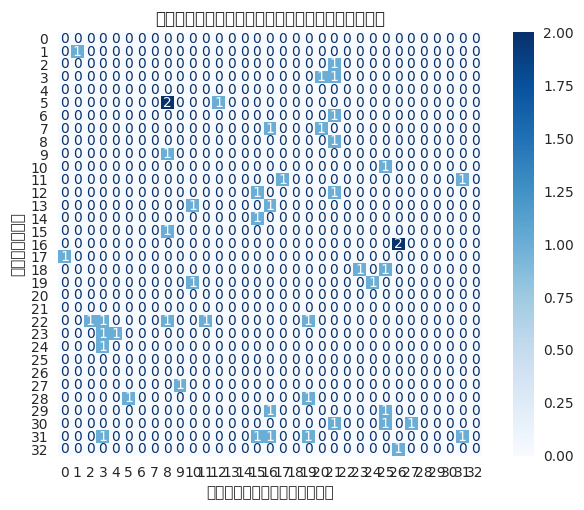

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



CUSTOM TEST
ผลการทดสอบด้วยข้อความกำหนดเอง:
กลยุทธ์: สาวงาม
เหตุผล: เดินหมากล่อศัตรูให้สับสนด้วยการเคลื่อนไหวเบา ๆ หลอกโฟกัสผิดจุด ก่อนรวบรวมกำลังหนีบกินอย่างเด็ดขาดในจังหวะที่ศัตรูประมาท
<|im_end|>


In [56]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm

# ตั้งค่าฟอนต์เป็น Noto Sans Thai
font_path = '/usr/share/fonts/truetype/noto/NotoSansThai-Regular.ttf'
matplotlib.rc('font', family=fm.FontProperties(fname=font_path).get_name())

# ===============================
# FINAL EVALUATION
# ===============================
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

# Evaluate on validation set
predictions, true_labels = evaluate_predictions(trainer.model, trainer.tokenizer, val_data, max_samples=50)

# Detailed evaluation report
accuracy = detailed_evaluation_report(true_labels, predictions)

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')

    plt.title('แผนภาพเมทริกซ์ความสับสน')
    plt.xlabel('ค่าที่คาดการณ์')
    plt.ylabel('ค่าจริง')
    plt.grid(False)
    plt.show()

plot_confusion_matrix(true_labels, predictions)

# ===============================
# CUSTOM TEST
# ===============================
print("\n" + "="*30)
print("CUSTOM TEST")
print("="*30)

custom_test = """- จำนวนการเดินหมาก: 8 ตา
- ผู้เล่น 1: 4 ตา, ผู้เล่น 2: 4 ตา
- การเดินแนวนอน: 2 ตา
- การเดินแนวตั้ง: 4 ตา
- ระยะทางเฉลี่ย: 2.5 ช่อง
ตาที่ 1: ผู้เล่น 1 เดิน (0,3) → (2,3)
ตาที่ 2: ผู้เล่น -1 เดิน (7,4) → (5,4)
ตาที่ 3: ผู้เล่น 1 เดิน (1,1) → (1,3)"""

result = test_custom_prediction(trainer.model, trainer.tokenizer, custom_test)
print("ผลการทดสอบด้วยข้อความกำหนดเอง:")
print(result)

In [47]:
# Save results
results = {
    'accuracy': accuracy,
    'predictions': predictions,
    'true_labels': true_labels,
    'test_result': result
}

with open('evaluation_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"\nTraining completed! Final accuracy: {accuracy:.3f}")
print("Results saved to evaluation_results.json")


Training completed! Final accuracy: 0.000
Results saved to evaluation_results.json


In [48]:
# ดูข้อมูลที่ถูก log ไว้ เช่น training loss, eval loss, step
for log in trainer.state.log_history:
    print(log)


{'loss': 1.8853, 'grad_norm': 1.0985430479049683, 'learning_rate': 3.6e-05, 'epoch': 0.1, 'step': 10}
{'loss': 1.4843, 'grad_norm': 0.8193488717079163, 'learning_rate': 7.6e-05, 'epoch': 0.2, 'step': 20}
{'eval_loss': 1.190882921218872, 'eval_runtime': 19.3095, 'eval_samples_per_second': 10.358, 'eval_steps_per_second': 5.179, 'epoch': 0.2, 'step': 20}
{'loss': 0.9272, 'grad_norm': 0.8505685329437256, 'learning_rate': 0.000116, 'epoch': 0.3, 'step': 30}
{'loss': 0.5261, 'grad_norm': 0.4968442916870117, 'learning_rate': 0.00015600000000000002, 'epoch': 0.4, 'step': 40}
{'eval_loss': 0.4589294195175171, 'eval_runtime': 20.2972, 'eval_samples_per_second': 9.854, 'eval_steps_per_second': 4.927, 'epoch': 0.4, 'step': 40}
{'loss': 0.4276, 'grad_norm': 0.46611517667770386, 'learning_rate': 0.000196, 'epoch': 0.5, 'step': 50}
{'loss': 0.3083, 'grad_norm': 0.4686777889728546, 'learning_rate': 0.00019936113105200085, 'epoch': 0.6, 'step': 60}
{'eval_loss': 0.2453867793083191, 'eval_runtime': 20.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [50]:
def analyze_training_logs(log_history):
    """
    วิเคราะห์และสร้างกราฟจาก training logs
    """
    train_logs = []
    eval_logs = []

    for log in log_history:
        if 'loss' in log and 'eval_loss' not in log:
            train_logs.append(log)
        elif 'eval_loss' in log:
            eval_logs.append(log)

    train_df = pd.DataFrame(train_logs)
    eval_df = pd.DataFrame(eval_logs)

    print("="*60)
    print("TRAINING ANALYSIS SUMMARY")
    print("="*60)

    print(f"Total Training Steps: {len(train_df)}")
    print(f"Total Evaluations: {len(eval_df)}")
    print(f"Final Epoch: {train_df['epoch'].iloc[-1]:.2f}" if len(train_df) > 0 else "No training data")

    if len(train_df) > 0:
        print(f"Initial Training Loss: {train_df['loss'].iloc[0]:.4f}")
        print(f"Final Training Loss: {train_df['loss'].iloc[-1]:.4f}")
        print(f"Training Loss Reduction: {train_df['loss'].iloc[0] - train_df['loss'].iloc[-1]:.4f}")
        print(f"Loss Improvement: {((train_df['loss'].iloc[0] - train_df['loss'].iloc[-1]) / train_df['loss'].iloc[0] * 100):.1f}%")

    if len(eval_df) > 0:
        print(f"Initial Eval Loss: {eval_df['eval_loss'].iloc[0]:.4f}")
        print(f"Final Eval Loss: {eval_df['eval_loss'].iloc[-1]:.4f}")
        print(f"Eval Loss Reduction: {eval_df['eval_loss'].iloc[0] - eval_df['eval_loss'].iloc[-1]:.4f}")
        print(f"Best Eval Loss: {eval_df['eval_loss'].min():.4f}")

    if 'learning_rate' in train_df.columns:
        print(f"Max Learning Rate: {train_df['learning_rate'].max():.2e}")
        print(f"Min Learning Rate: {train_df['learning_rate'].min():.2e}")
        print(f"Final Learning Rate: {train_df['learning_rate'].iloc[-1]:.2e}")

    if 'grad_norm' in train_df.columns:
        print(f"Average Gradient Norm: {train_df['grad_norm'].mean():.4f}")
        print(f"Max Gradient Norm: {train_df['grad_norm'].max():.4f}")
        print(f"Gradient Norm Std: {train_df['grad_norm'].std():.4f}")

    print("="*60)

    create_training_plots(train_df, eval_df)

    return train_df, eval_df

In [51]:
def create_training_plots(train_df, eval_df):
    # 1. Loss Curves
    plt.figure(figsize=(10, 6))
    if len(train_df) > 0:
        plt.plot(train_df['step'], train_df['loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    if len(eval_df) > 0:
        plt.plot(eval_df['step'], eval_df['eval_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Loss Curves', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('loss_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 2. Learning Rate Schedule
    plt.figure(figsize=(10, 6))
    if len(train_df) > 0 and 'learning_rate' in train_df.columns:
        plt.plot(train_df['step'], train_df['learning_rate'], 'g-', linewidth=2, marker='o', markersize=3)
        plt.xlabel('Training Steps')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        plt.grid(True, alpha=0.3)
    plt.savefig('learning_rate.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 3. Gradient Norm
    plt.figure(figsize=(10, 6))
    if len(train_df) > 0 and 'grad_norm' in train_df.columns:
        plt.plot(train_df['step'], train_df['grad_norm'], 'purple', linewidth=2, marker='o', markersize=3)
        plt.xlabel('Training Steps')
        plt.ylabel('Gradient Norm')
        plt.title('Gradient Norm', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Clipping Threshold')
        plt.legend()
    plt.savefig('gradient_norm.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 4. Loss by Epoch
    plt.figure(figsize=(10, 6))
    if len(train_df) > 0:
        plt.plot(train_df['epoch'], train_df['loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    if len(eval_df) > 0:
        plt.plot(eval_df['epoch'], eval_df['eval_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss by Epoch', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('loss_by_epoch.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 5. Loss Smoothing
    plt.figure(figsize=(10, 6))
    if len(train_df) > 5:
        window_size = max(1, len(train_df) // 10)
        train_df_copy = train_df.copy()
        train_df_copy['loss_smooth'] = train_df_copy['loss'].rolling(window=window_size, center=True).mean()
        plt.plot(train_df_copy['step'], train_df_copy['loss'], alpha=0.3, color='lightblue', label='Raw Loss')
        plt.plot(train_df_copy['step'], train_df_copy['loss_smooth'], 'darkblue', linewidth=3, label='Smoothed Loss')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title('Loss Smoothing', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
    plt.savefig('loss_smoothing.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 6. Evaluation Performance
    plt.figure(figsize=(10, 6))
    if len(eval_df) > 0:
        metrics = ['eval_samples_per_second', 'eval_runtime']
        colors = ['orange', 'brown']
        for i, metric in enumerate(metrics):
            if metric in eval_df.columns:
                ax = plt.gca() if i == 0 else plt.gca().twinx()
                ax.plot(eval_df['step'], eval_df[metric], color=colors[i],
                       linewidth=2, marker='o', markersize=4, label=metric.replace('_', ' ').title())
                ax.set_ylabel(metric.replace('_', ' ').title(), color=colors[i])
                ax.tick_params(axis='y', labelcolor=colors[i])
        plt.xlabel('Training Steps')
        plt.title('Evaluation Performance', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
    plt.savefig('evaluation_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [52]:
def create_detailed_summary_table(train_df, eval_df):
    print("\n" + "="*80)
    print("DETAILED TRAINING METRICS")
    print("="*80)

    if len(train_df) > 0:
        print("\nTRAINING METRICS:")
        print("-" * 40)
        summary_data = {
            'Metric': ['Initial Loss', 'Final Loss', 'Best Loss', 'Loss Reduction', 'Avg Gradient Norm', 'Max Gradient Norm'],
            'Value': [
                f"{train_df['loss'].iloc[0]:.4f}",
                f"{train_df['loss'].iloc[-1]:.4f}",
                f"{train_df['loss'].min():.4f}",
                f"{train_df['loss'].iloc[0] - train_df['loss'].iloc[-1]:.4f}",
                f"{train_df['grad_norm'].mean():.4f}" if 'grad_norm' in train_df.columns else 'N/A',
                f"{train_df['grad_norm'].max():.4f}" if 'grad_norm' in train_df.columns else 'N/A'
            ]
        }
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))

    if len(eval_df) > 0:
        print("\nEVALUATION METRICS:")
        print("-" * 40)
        eval_summary = {
            'Metric': ['Initial Eval Loss', 'Final Eval Loss', 'Best Eval Loss', 'Eval Loss Reduction', 'Avg Eval Time', 'Avg Samples/Sec'],
            'Value': [
                f"{eval_df['eval_loss'].iloc[0]:.4f}",
                f"{eval_df['eval_loss'].iloc[-1]:.4f}",
                f"{eval_df['eval_loss'].min():.4f}",
                f"{eval_df['eval_loss'].iloc[0] - eval_df['eval_loss'].iloc[-1]:.4f}",
                f"{eval_df['eval_runtime'].mean():.2f}s" if 'eval_runtime' in eval_df.columns else 'N/A',
                f"{eval_df['eval_samples_per_second'].mean():.2f}" if 'eval_samples_per_second' in eval_df.columns else 'N/A'
            ]
        }
        eval_summary_df = pd.DataFrame(eval_summary)
        print(eval_summary_df.to_string(index=False))

    if len(train_df) > 1:
        print("\nTRAINING EFFICIENCY:")
        print("-" * 40)
        total_steps = train_df['step'].iloc[-1]
        total_epochs = train_df['epoch'].iloc[-1]
        loss_per_step = (train_df['loss'].iloc[0] - train_df['loss'].iloc[-1]) / total_steps
        efficiency_data = {
            'Metric': ['Total Steps', 'Total Epochs', 'Loss Reduction per Step', 'Steps per Epoch'],
            'Value': [
                f"{total_steps}",
                f"{total_epochs:.2f}",
                f"{loss_per_step:.6f}",
                f"{total_steps/total_epochs:.1f}" if total_epochs > 0 else 'N/A'
            ]
        }
        efficiency_df = pd.DataFrame(efficiency_data)
        print(efficiency_df.to_string(index=False))

In [53]:
  def analyze_your_training_logs(trainer):
      """
      ใช้ฟังก์ชันนี้กับ trainer ของคุณ
      """
      log_history = trainer.state.log_history

      train_df, eval_df = analyze_training_logs(log_history)
      create_detailed_summary_table(train_df, eval_df)

      if len(train_df) > 0:
          train_df.to_csv('training_logs.csv', index=False)
          print(f"\nTraining data saved to: training_logs.csv")
      if len(eval_df) > 0:
          eval_df.to_csv('evaluation_logs.csv', index=False)
          print(f"Evaluation data saved to: evaluation_logs.csv")

      return train_df, eval_df

TRAINING ANALYSIS SUMMARY
Total Training Steps: 30
Total Evaluations: 15
Final Epoch: 3.00
Initial Training Loss: 1.8853
Final Training Loss: 0.0443
Training Loss Reduction: 1.8410
Loss Improvement: 97.7%
Initial Eval Loss: 1.1909
Final Eval Loss: 0.0446
Eval Loss Reduction: 1.1463
Best Eval Loss: 0.0446
Max Learning Rate: 1.99e-04
Min Learning Rate: 7.90e-09
Final Learning Rate: 7.90e-09
Average Gradient Norm: 0.2810
Max Gradient Norm: 1.0985
Gradient Norm Std: 0.2570


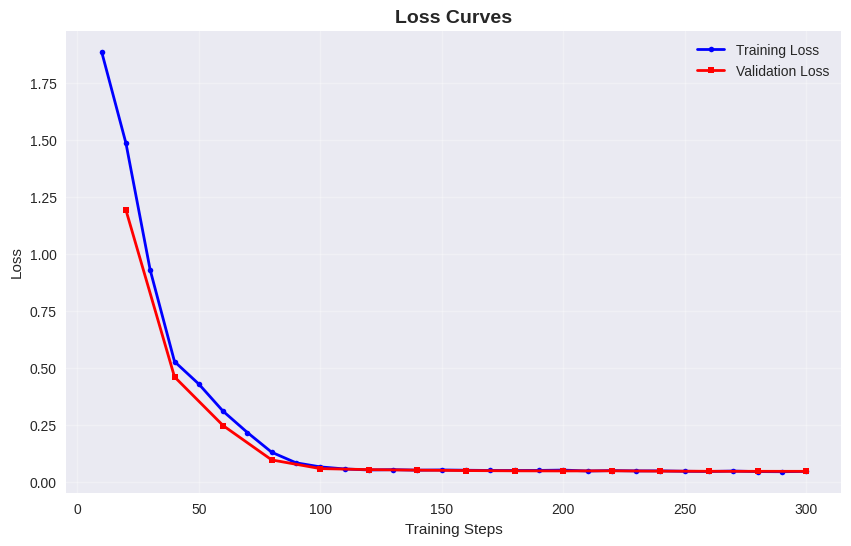

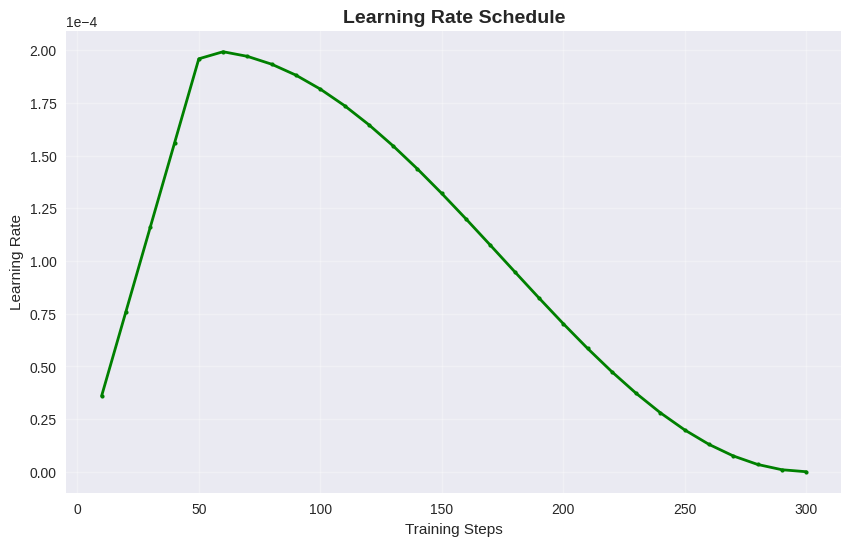

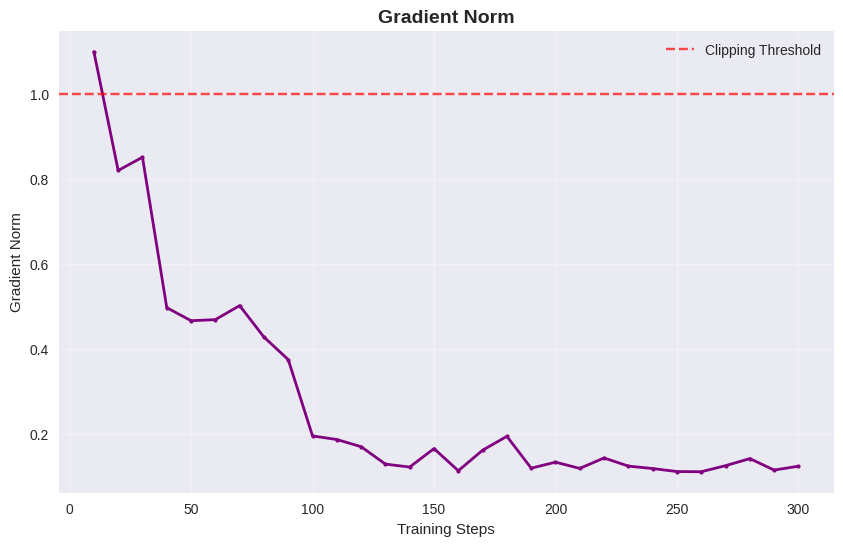

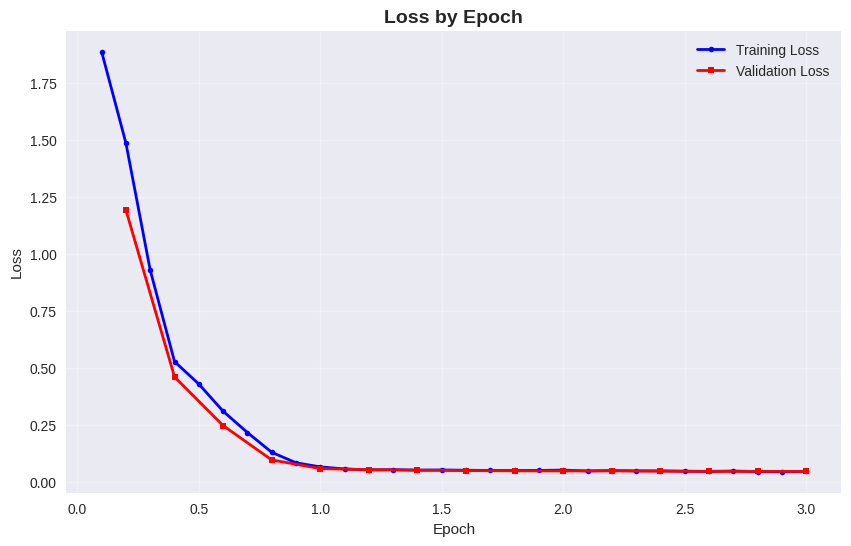

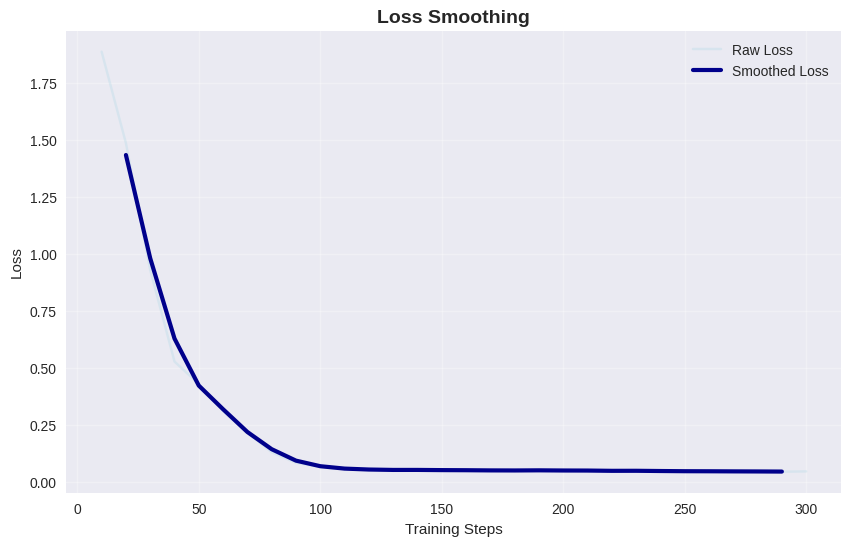

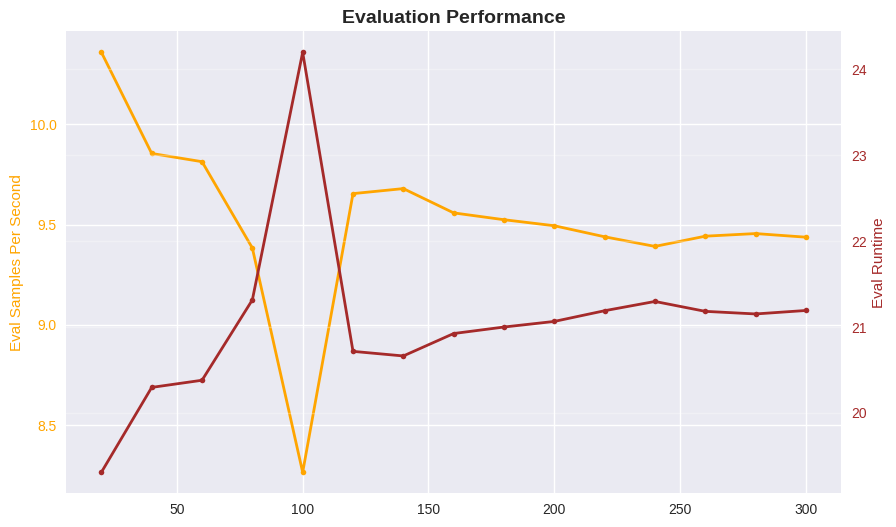


DETAILED TRAINING METRICS

TRAINING METRICS:
----------------------------------------
           Metric  Value
     Initial Loss 1.8853
       Final Loss 0.0443
        Best Loss 0.0429
   Loss Reduction 1.8410
Avg Gradient Norm 0.2810
Max Gradient Norm 1.0985

EVALUATION METRICS:
----------------------------------------
             Metric  Value
  Initial Eval Loss 1.1909
    Final Eval Loss 0.0446
     Best Eval Loss 0.0446
Eval Loss Reduction 1.1463
      Avg Eval Time 21.06s
    Avg Samples/Sec   9.52

TRAINING EFFICIENCY:
----------------------------------------
                 Metric    Value
            Total Steps      300
           Total Epochs     3.00
Loss Reduction per Step 0.006137
        Steps per Epoch    100.0

Training data saved to: training_logs.csv
Evaluation data saved to: evaluation_logs.csv


In [54]:
train_df, eval_df = analyze_your_training_logs(trainer)